# Python in C

V tem poglavju si bomo ogledali malo več o delovanju Pythona pod pokrovom in njegovi povezavi s C-jem. Do sedaj smo se učili Python uporabljati, tu pa se bomo posvetili malo več podrobnostim samega delovanja interpreterja za Python.

Python je programski jezik, ki definira pravila, kako naj bi se pisali in nato obnašali programi napisani v njem. Interpreter pa je tisti, ki ta pravila upošteva in jih dejansko izvaja. Delovanje interpreterjev in prevajalnikov je precej obsežno področje, zato si bomo samo površno ogledali osnovne ideje. V čem je napisan interpreter za Python? Je samo en, ali jih obstaja več?

## CPython

Najbolj razširjena implementacija Pythona, ki jo dobite na https://www.python.org/, je CPython. Kot razkriva že ime, je napisan v C-ju. Za začetek povejmo, da ločnica med prevajalniki in interpreterji ni tako jasna, kot vam je bila morda kdaj predstavljena. CPython namreč vsebuje oba koncepta (https://github.com/python/cpython/tree/main/InternalDocs). Program v Pythonu se najprej *prevede* v vmesno kodo (angl. byte-code), ki se nato *interpretira* za izvedbo programa. Oba dela sta napisana v C-ju.

Vmesna koda je verjetno najbolj znana iz programskega jezika Java, kjer je razlog za njeno uporabo v kompatibilnosti na različnih platformah, ki sicer zahtevajo različne implementacije izvajanja vmesne kode, ne pa tudi prevajanja v njo. Pri Pythonu pa je razlog v hitrosti, ker je predstavitev z vmesno kodo že nekoliko obdelana ter zato bolj kompaktna, enostavna in učinkovita za nadaljnje izvajanje.

Prevajanje v vmesno kodo in njeno izvajanje se normalno izvedeta v enem koraku, npr. ob klicu `python primer.py`. Tu pa si na kratkem primeru oglejmo vmesne stopnje.

In [6]:
def primer():
    a = 10
    print(a+3)

Ukaz `python -m py_compile primer.py` bi ustvaril v direktoriju `__pycache__` prevedeno različico s končnico `.pyc`. To je sicer vmesni korak izvajanja Python skripte, tu pa ta vmesni produkt še shranimo. Ker vsebina ni berljiva, jo lahko z modulom `dis` (disassembly) prikažemo v ljudem bolj prijazni obliki. Pogledamo lahko vmesno kodo funkcije `primer` oz. njeno jasnejšo predstavitev. Vidimo, da se operatorji nalagajo na nek sklad, operacije pa se izvajajo nad elementi na vrhu sklada, kamor se odlagajo tudi rezultati funkcij.

In [7]:
import dis
dis.dis(primer)

  1           0 RESUME                   0

  2           2 LOAD_CONST               1 (10)
              4 STORE_FAST               0 (a)

  3           6 LOAD_GLOBAL              1 (NULL + print)
             18 LOAD_FAST                0 (a)
             20 LOAD_CONST               2 (3)
             22 BINARY_OP                0 (+)
             26 PRECALL                  1
             30 CALL                     1
             40 POP_TOP
             42 LOAD_CONST               0 (None)
             44 RETURN_VALUE


Obstajajo tudi druge implementacije Pythona (https://www.python.org/download/alternatives/), omenimo dve:

- PyPy (https://pypy.org/) je implementacija Pythona v Pythonu (logo projekta je kača, ki jé svoj rep). Pravzaprav je interpreter implementiran v omejen naboru Pythona, ki mu rečejo RPython (restricted). Uporablja Just-In-Time (JIT) prevajanje, kjer se določeni deli kode med izvajanjem avtomatsko prevedejo v C in nato v strojno kodo, ki se izvede za pohitritev tistega dela programa.

- Jython je implementacija Pythona v Javi, ki prevede Python program v javansko vmesno kodo, ki jo lahko nato izvaja poljuben JVM (Java Virtual Machine, javanski navidezni stroj), tako kot vse ostale programe v Javi.

## Razširitev Pythona s C-jem

Ker je Python običajno implementiran v C-ju, je smiselno pričakovati, da ga je mogoče razširiti s funkcionalnostmi napisanimi v C-ju. Seveda pa je ta funkcionalnost specifična za CPython (https://docs.python.org/3/extending/extending.html). Naše razširitve bodo morale uporabljati enake objekte, kot jih uporablja CPython za izvajanje programa napisanega v Pythonu. Glavna razloga za tako kompliciranje sta:
- učinkovitejše izvajanje kritičnega dela programa ali
- že obstoječa funkcionalnost v neki C/C++ funkciji oz. knjižnici.

#### Obstoječa implementacija

Za začetek si oglejmo, kako je v CPythonu implementirana funkcija `isqrt` (celoštevilski koren). Funkcija `isqrt` je dovolj redko uporabljena, da nas [iskanje po repozitoriju](https://github.com/search?q=repo:python/cpython+isqrt&type=code) hitro pripelje na pravo mesto. Implementacija se nahaja v datoteki za celoštevilsko aritmetiko [Modules/mathintegermodule.c](https://github.com/python/cpython/blob/main/Modules/mathintegermodule.c). Ta vsebuje definicijo funkcije `math_integer_isqrt`, ki vrne napako, če je število negativno, obravnava primer, ko je število nič, ima posebno logiko, če gre za manjša 64-bitna števila, uporablja vnaprej tabelirane vrednosti, ... Na koncu datoteke pa se nahaja logika za registracijo modula, ki pripravi opis modula `math_integer_module` (s seznamom ponujenih funkcij - `math_integer_methods`) in izvede registracijo v funkciji `PyInit__math_integer`. Nekaj podobnega bomo morali izvesti za implementacijo svojega modula.

#### Lastni modul

Kot primer bomo napisali modul `aritm` v C-ju, ki bo ponujal funkcijo `add` za seštevanje dveh celih števil. Rešitev bo implementirana v datoteki `libaritm.c`, ki je prikazana v nadaljevanju. Za kompatibilnost s CPythonom moramo uporabljati objekte kot so `PyObject` ali funkcija `PyLong_FromLong`, ki so navedeni v knjižnici `Python.h`.

Funkcija add sprejme Pythonov objekt `self` (ki se nanaša na modul v primeru običajne funkcije ali pa na instanco objekta v primeru metode razreda) in argumente funkcije `args` preko kazalcev, ki jih s pomočjo funkcije `PyArg_ParseTuple` razpakira v dve C-jevksi celi števili. Nato ju sešteje in rezultat s funkcijo `PyLong_FromLong` pretvori iz C-jevskega celega števila v objekt, ki predstavlja Pythonovo celo število.

Poleg definicije funkcije pa potrebujemo tudi nekaj dodatne kode, ki bo poskrbela, da bo ta funkcija dostopna programom v Pythonu, sicer CPython ne bo vedel, da sploh obstaja kakšna rezširitev. Pripraviti moramo opis funkcij (`aritm_funcs`) in opis modula (`aritm_mod`), ki ga nato uporabimo za inicializacijo modula s funkcijo `PyInit_aritm`.

In [11]:
%%writefile libaritm.c

#include <Python.h>

PyObject* add(PyObject *self, PyObject *args) {
	int x, y;
	if (!PyArg_ParseTuple(args, "ii", &x, &y)) return NULL;
	int z = x + y;
	return PyLong_FromLong(z);
}

PyMethodDef aritm_funcs[] = {
    {"add", add, METH_VARARGS, "Sestej dve celi stevili"},
    {NULL}
};

PyModuleDef aritm_mod = {
	PyModuleDef_HEAD_INIT,
	"aritm",
	"Modul za aritmeticne operacije",
	-1,
	aritm_funcs
};

PyMODINIT_FUNC PyInit_aritm(void) {
	return PyModule_Create(&aritm_mod);
}

Writing libaritm.c


Da bomo lahko svojo knjižnico uporabljali, jo moramo najprej prevesti. To najlažje prepustimo Pythonu z uporabo knjižnice `setuptools`, da bo preveden rezultat kompatibilen s preostankom CPythona. Uporabimo lahko sledečo datoteko `setup.py` z navodili za prevajanje, ki jo izvedemo z ukazom `python setup.py build_ext --inplace`. Ta prevede navedene razširitve (`build_ext`) in jih ne vključi (`--inplace`) med splošne knjižnice, temveč jih pusti na trenutnem mestu za nadaljnje spreminjanje.

In [12]:
%%writefile setup.py

from setuptools import setup, Extension

setup(
    name = "aritm",
    version = "1.0",
    ext_modules = [Extension("aritm", ["libaritm.c"])]
)

Writing setup.py


In [16]:
! python setup.py build_ext --inplace

running build_ext


Sedaj imamo vse pripravljeno za uporabo svoje knjižnice.

In [17]:
import aritm

print(aritm.add(5, 6))

11


### ctypes

Alternativa vkomponiranju lastnih funkcij v delovanje interpreterja so t.i. "Foreign Function Interface" knjižnice, kot je npr. ctypes (https://docs.python.org/3/library/ctypes.html). Te celoten proces poenostavijo, sploh če želimo dostopati do obstoječih knjižnic, ki so napisane v C-ju. Hkrati pa ga nekoliko omejijo, ker si ne moremo privoščiti toliko fleksibilnosti, kot bi si jo lahko sicer, npr. s spreminjanjem raznih Pythonovih internih objekte. To morda ni slaba stvar, ker je tudi manj možnosti, da kaj ponesreči pokvarimo.

In [18]:
from ctypes import *

Oglejmo si najprej primer, kjer bomo naložili standardno C-jevsko knjižnico in uporabljali njene funkcije. Na Windowsih je na voljo kot `msvcrt.dll` (Microsoft C run-time library), na Linuxu in macOSu pa jo lahko najdete z `find_library("c")` iz `ctypes.util`.

In [19]:
libc = CDLL("msvcrt.dll")
print(libc.abs(-8))

8


Zunanje funkcije vključene s ctypes knjižnico sprejemajo in vračajo spremenljivke tipa `int`. Če temu ni tako, moramo tipe posebej navesti, da se izvede primerna pretvorba.

In [20]:
libc.pow.restype = c_double
libc.pow.argtypes = (c_double, c_double)
print(libc.pow(2.5, 2))

6.25


Knjižnica omogoča tudi povezavo z lastnimi knjižnicami implementiranimi v C-ju, kar je veliko enostavnejše od dela neposredno s CPython-ovimi konstrukti.

In [21]:
%%writefile libaritm-ctypes.c

int add_int(int x, int y) {
    return x+y;
}

double add_double(double x, double y) {
    return x+y;
}

Writing libaritm-ctypes.c


Seveda pa moramo tudi to pred uporabo prevesti v deljeno knjižnico (angl. shared library). Tokrat je prevajanje bolj enostavno, ker ustvarjamo samostojno knjižnico, za integracijo s Pythonom pa bo poskrbel ctypes ob nalaganju.

In [23]:
! gcc -shared -o libaritm-ctypes.dll libaritm-ctypes.c

Svojo knjižnico lahko sedaj naložimo in uporabljamo.

In [24]:
aritm = CDLL("./libaritm-ctypes.dll")

print(aritm.add_int(2, 3))

aritm.add_double.restype = c_double
aritm.add_double.argtypes = [c_double, c_double]
print(aritm.add_double(1.5, 2))

5
3.5


## Cython

Ročnemu pisanju delov kode v C-ju zavoljo hitrosti pa se lahko povsem izognemo. Posamezne module napisane v Python lahko s paketom Cython (https://cython.org/) namreč avtomatsko prevedemo v C.

Moč take optimizacije bomo demonstrirali na dokaj kompleksnem primeru zameglitve slike. Sliko naložimo s knjižnico `matplotlib` v obliki 2D `numpy` tabele števil tipa `double`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(280, 249)


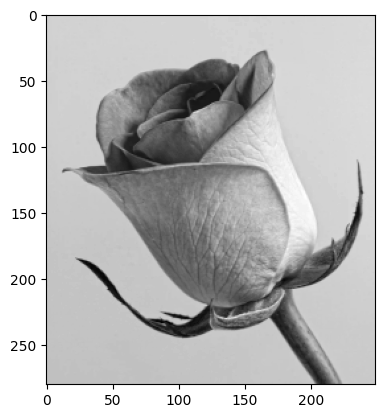

In [2]:
img = plt.imread('rose.png').astype(np.double)
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

Zameglitev bomo implementirali z lastno funkcijo `blur`, ki bo poleg slike sprejela še njene dimenzije in stopnjo zameglitve $k$. Vsak piksel bomo zamenjali s povprečno vrednostjo piksla v okolici $\pm k$ pikslov.

In [3]:
def blur(img, h, w, k):
    result = np.zeros((h, w), dtype=np.double)
    for i in range(h):
        for j in range(w):
            total, num = 0, 0
            for di in range(-k,k+1):
                for dj in range(-k,k+1):
                    if 0<=i+di<h and 0<=j+dj<w:
                        total += img[i+di][j+dj]
                        num += 1
            result[i][j] = total/num
    return result

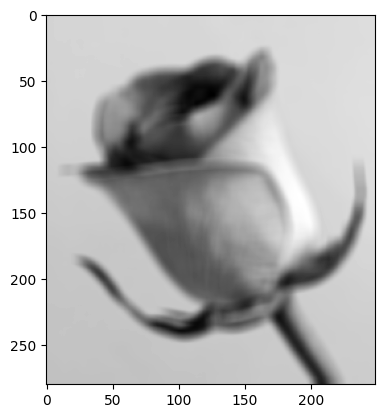

In [4]:
img_blur = blur(img, *img.shape, 4)
plt.imshow(img_blur, cmap="gray")
plt.show()

Seveda obstajajo hitrejši algoritmi za izračun istega rezultata, vendar bomo poskusili pohitriti ta najbolj osnoven algoritem. Izbrali smo postopek, ki Pythonu še posebej ne ustreza - premikanje po strukturah z indeksi in gnezdenimi zankami. Čas računanja za to dokaj majhno sliko velikosti cca. $280 \times 250$ je več kot 2 sekundi. Za večje slike bi bilo računanje temu primerno počasnejše. 

In [5]:
%timeit blur(img, *img.shape, 4)

2.07 s ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Pohitrimo našo rešitev z uporabo Cythona. Funkcijo bomo premaknili v svoj modul s končnico `.pyx`, ki ga bomo nato prevedli s Cythonom. Ta bo modul prevedel v C in ga tako pripravil za hitrejše izvajanje.

In [6]:
%%writefile libblur1.pyx

import numpy as np

def blur(img, h, w, k):
    result = np.zeros((h, w), dtype=np.double)
    for i in range(h):
        for j in range(w):
            total, num = 0.0, 0
            for di in range(-k,k+1):
                for dj in range(-k,k+1):
                    if 0<=i+di<h and 0<=j+dj<w:
                        total += img[i+di][j+dj]
                        num += 1
            result[i][j] = total/num
    return result

Overwriting libblur1.pyx


Prevajanje lahko izvedemo eksplicitno z uporabo ukaza `cythonize`, ali pa v končnem izdelku ta korak vključimo v datoteko `setup.py`. Preveden modul naj se ustvari poleg trenutne datoteke (inplace), poleg tega pa naj se ustvarijo še anotacije kode, ki prikazujejo interakcijo s Pythonovimi objekti.

In [8]:
! cythonize --annotate --inplace libblur1.pyx

running build_ext


Nastala je datoteka `libblur1.c`, ki si jo oglejmo. Na tak način generirana koda je za programerja precej neberljiva, je pa zato precej učinkovita. Vsebuje tudi oznake, v kaj se je prevedel kateri del iz pyx datoteke. Trivialna inicializacija spremenljivke `total = 0` se je prevedla v 
```C
__pyx_t_5 = __pyx_float_0_0;
__Pyx_INCREF(__pyx_t_5);
__Pyx_XDECREF_SET(__pyx_v_total, __pyx_t_5);
__pyx_t_5 = 0;
```
Ta koda vključuje Pythonovske objekte, vendar bi jo lahko poenostavili v delo z navadnim `int`-om v C-ju (in brez štetja referenc nanj). Preverimo, koliko smo pridobili do sedaj samo s prevedbo v C.

In [10]:
import libblur1

In [11]:
%timeit libblur1.blur(img, *img.shape, 4)

1.61 s ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Koda je hitrejša za približno 20\%, kar ni slabo, vendar je še ogromno prostora za enostavne izboljšave. Pri iskanju mest za poenostavitev si lahko pomagamo z anotirano kodo v nastali datoteki `libblur1.html` (opcija --anotate).

In [12]:
from IPython.display import IFrame

IFrame(src='libblur1.html', width=800, height=500)

- Številnih nepotrebnih interakcij s Pythonom se lahko znebimo že z anotacijo tipov. Če označimo v Cythonu, da je neka spremenljivka navaden C-jevski `int`, se lahko koda precej poenostavi. To storimo na enak način, kot smo navajeni anotacije tipov v Pythonu, le da bomo uporabljali Cython-ove anotacijske tipe, kot je npr. `cython.int`.
- Dvodimenzionalne numpy tabele, ki so strnjeni kosi pomnilnika, označimo kot `cython.double[:, :]`.
- Tako anotacijo uporabimo tudi za delo z izhodno tabelo `result`, v katero bomo zapisovali vrednosti. S tem dobimo t.i. pogled (memoryview) `view` do podatkov, da lahko pišemo vanje neposredno mimo vse dodatne Pythonove logike.
- Posebej bomo onemogočili tudi preverjanje mej indeksov in uporabo negativnih indeksov (za dostop od zadaj).

In [13]:
%%writefile libblur2.pyx

import cython
import numpy as np

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing
def blur(img: cython.double[:, :], h: cython.int, w: cython.int, k: cython.int) -> cython.double[:, :]:
    h: cython.int; w: cython.int
    i: cython.int; j: cython.int
    di: cython.int; dj: cython.int

    result = np.zeros((h, w), dtype=np.double)
    view: cython.double[:, :] = result

    for i in range(h):
        for j in range(w):
            total: cython.double = 0.0
            num: cython.int = 0
            for di in range(-k,k+1):
                for dj in range(-k,k+1):
                    if 0<=i+di<h and 0<=j+dj<w:
                        total += img[i+di][j+dj]
                        num += 1
            view[i][j] = total/num
    return result

Overwriting libblur2.pyx


In [15]:
! cythonize --annotate --inplace libblur2.pyx

running build_ext


V anotirani kodi lahko preverimo, da je interakcij s Python objekti precej manj in je koda veliko bolj C-jevska brez dodatne logike. Npr. inicializacija spremenljivke `total = 0.0` se sedaj prevede direktno v `__pyx_v_total = 0.0`.

In [16]:
from IPython.display import IFrame

IFrame(src='libblur2.html', width=800, height=500)

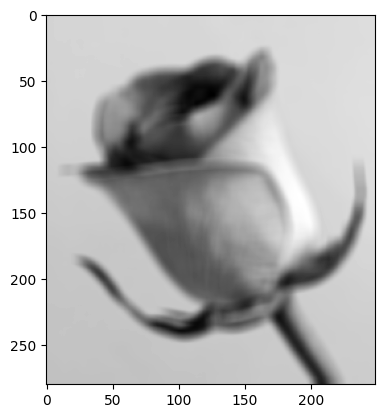

In [17]:
import libblur2

img_blur = libblur2.blur(img, *img.shape, 4)
plt.imshow(img_blur, cmap="gray")
plt.show()

Koda deluje in vrne enak rezultat kot originalen poskus zameglitve slike. Koliko pa je nova rešitev s prevajanjem modula s Cythonom hitrejša?

In [18]:
%timeit libblur2.blur(img, *img.shape, 4)

14.7 ms ± 283 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ta rešitev se je izkazala za kar 140-krat hitrejšo od direktne implementacije v Pythonu!

S premikom funkcionalnosti v ločen modul in nekaj enostavnimi anotacijami tipov lahko s pomočjo Cythona, ki vnaprej prevede modul v C, v tem primeru dosežemo več kot 100-kratno pohitritev. Tako bi lahko v enakem času zameglili sliko, ki je kar 10-krat širša in 10-krat višja.